In [1]:
import pandas as pd
import os
import joblib
from keras.src.layers import TextVectorization, LayerNormalization, GlobalAveragePooling1D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import (
    Embedding, GlobalMaxPooling1D, Attention, Input, LSTM, Bidirectional, Dense, MultiHeadAttention, LayerNormalization, Dropout, Conv1D, MaxPooling1D, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras_hub
import warnings

from tensorflow.python.keras.models import save_model

warnings.filterwarnings("ignore")

2024-12-07 16:43:46.501352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733618626.523162  311721 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733618626.529810  311721 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 16:43:46.553460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please upd

In [2]:
# load in the data
human = pd.read_csv('Data/human_final.csv')
thaliana = pd.read_csv('Data/ara_tha_final.csv')
mouse = pd.read_csv('Data/mouse_mus_final.csv')


In [3]:
# adding a species column and promoter_status column
human['Species'] = 'Human'
thaliana['Species'] = 'Thaliana'
mouse['Species'] = 'Mouse'
human['Promoter Status'] = human['Promoter ID'].str.contains('FP')
thaliana['Promoter Status'] = thaliana['Promoter ID'].str.contains('FP')
mouse['Promoter Status'] = mouse['Promoter ID'].str.contains('FP')
combined_data = pd.concat([human, thaliana, mouse], axis=0)
combined_data['Lengths'] = combined_data['Sequence'].str.len()

In [4]:
# plotting the lengths of the sequences
combined_data.value_counts(subset=['Species', 'Lengths'])

Species   Lengths
Human     351        36925
Mouse     351        35170
Thaliana  351        26349
Name: count, dtype: int64

In [5]:
# getting the counts of each prompoter stats by species
min_group_size = combined_data.groupby(['Species', 'Promoter Status']).size().min()
# limiting the number of samples to the smallest group size
combined_data = combined_data.groupby(['Species', 'Promoter Status']).apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)
combined_data.groupby(['Species', 'Promoter Status']).size()

Species   Promoter Status
Human     False              12944
          True               12944
Mouse     False              12944
          True               12944
Thaliana  False              12944
          True               12944
dtype: int64

In [6]:
# creating a dict that contains the train, test split for each species as well as combined data
train_test_splits = {}
for species in combined_data['Species'].unique():
    species_data = combined_data[combined_data['Species'] == species]
    train_test_splits[species]= {}
    train_test_splits[species]['x_train'], train_test_splits[species]['x_test'],train_test_splits[species]['y_train'], train_test_splits[species]['y_test'] =  train_test_split(species_data['Sequence'], species_data['Promoter Status'], test_size=0.2)
train_test_splits['Combined'] = {}
train_test_splits['Combined']['x_train'] = pd.concat([train_test_splits[species]['x_train'] for species in combined_data['Species'].unique()], axis=0)
train_test_splits['Combined']['x_test'] = pd.concat([train_test_splits[species]['x_test'] for species in combined_data['Species'].unique()], axis=0)
train_test_splits['Combined']['y_train'] = pd.concat([train_test_splits[species]['y_train'] for species in combined_data['Species'].unique()], axis=0)
train_test_splits['Combined']['y_test'] = pd.concat([train_test_splits[species]['y_test'] for species in combined_data['Species'].unique()], axis=0)


### Setting KmerVectorizer for the rest of the notebook

In [7]:
class KmerVectorizer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to vectorize k-mers for different K values.
    """
    def __init__(self, K=3):
        self.K = K
        self.vectorizer = None

    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(analyzer='char', ngram_range=(self.K, self.K))
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        return self.vectorizer.transform(X)

### Setting up an evaluation function for the rest of notebook

In [8]:
def evaluate_model(best_model, species_list, splits, model_name, attention=False, max_length=None, probability=True, ax_prob=None, ax_roc=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
    import pandas as pd
    import numpy as np

    # Store metrics and plot data
    metrics_list = []
    prob_data = []
    roc_data = []

    for species in species_list:
        x_test = splits[species]['x_test']
        y_test = splits[species]['y_test']

        # Check if model is a Keras model
        if isinstance(best_model, tf.keras.Model):
            if not attention:
                x_test_tensor = tf.constant(x_test, dtype=tf.string)
            else:
                x_test_tokenized = x_test.apply(lambda x: dna_tokenizer(x, max_length=max_length))
                x_test_tensor = tf.keras.preprocessing.sequence.pad_sequences(x_test_tokenized, maxlen=max_length)
            y_prob = best_model.predict(x_test_tensor, verbose=0).flatten().astype(np.float64)
        else:
            if hasattr(best_model, "predict_proba"):
                y_prob = best_model.predict_proba(x_test)[:, 1]
            else:
                y_prob = best_model.predict(x_test)

        y_test = np.array(y_test)
        y_prob = np.array(y_prob)
        y_pred = (y_prob > 0.5).astype(int)

        # Compute metrics
        metrics = {
            'model': model_name,
            'species': species,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0)
        }

        # Append probability data for KDE plot
        prob_data.extend([(species, prob) for prob in y_prob])

        # Compute and store ROC data
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        metrics['roc_auc'] = roc_auc
        roc_data.extend([(species, f, t) for f, t in zip(fpr, tpr)])

        metrics_list.append(metrics)

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.set_index('species', inplace=True)

    # Convert probability data and ROC data to DataFrames
    prob_df = pd.DataFrame(prob_data, columns=['species', 'probability'])
    roc_df = pd.DataFrame(roc_data, columns=['species', 'fpr', 'tpr'])

    # Plotting the probabilities KDE
    if probability:
        if ax_prob is None:
            plt.figure(figsize=(12, 6))
            sns.kdeplot(data=prob_df, x='probability', hue='species', common_norm=False)
            plt.title(f"Probability Distribution for {model_name}")
            plt.xlabel("Predicted Probability")
            plt.ylabel("Density")
            plt.savefig(f"{model_name}_combined_probability_distribution.png")
            plt.show()
        else:
            sns.kdeplot(data=prob_df, x='probability', hue='species', common_norm=False, ax=ax_prob)
            ax_prob.set_title(f"Probability Distribution for {model_name}")
            ax_prob.set_xlabel("Predicted Probability")
            ax_prob.set_ylabel("Density")

    # Create combined ROC curve plot
    if ax_roc is None:
        plt.figure(figsize=(8, 8))
        for species in species_list:
            species_data = roc_df[roc_df['species'] == species]
            auc_score = metrics_df.loc[species, 'roc_auc']
            accuracy = metrics_df.loc[species, 'accuracy']
            plt.plot(species_data['fpr'], species_data['tpr'],
                     label=f"{species} (AUC = {auc_score:.2f}, Acc = {accuracy:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
        plt.title(f"ROC Curve for {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right", title='Species')
        plt.savefig(f"{model_name}_combined_roc_curves.png")
        plt.show()
    else:
        for species in species_list:
            species_data = roc_df[roc_df['species'] == species]
            auc_score = metrics_df.loc[species, 'roc_auc']
            accuracy = metrics_df.loc[species, 'accuracy']
            ax_roc.plot(species_data['fpr'], species_data['tpr'],
                        label=f"{species} (AUC = {auc_score:.2f}, Acc = {accuracy:.2f})")
        ax_roc.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
        ax_roc.set_title(f"ROC Curve for {model_name}")
        ax_roc.set_xlabel("False Positive Rate")
        ax_roc.set_ylabel("True Positive Rate")
        ax_roc.legend(loc="lower right", title='Species')

    return metrics_df


### Testing TruncatedSVD on various K values

0 0
1 0
2 0
0 1
1 1
2 1


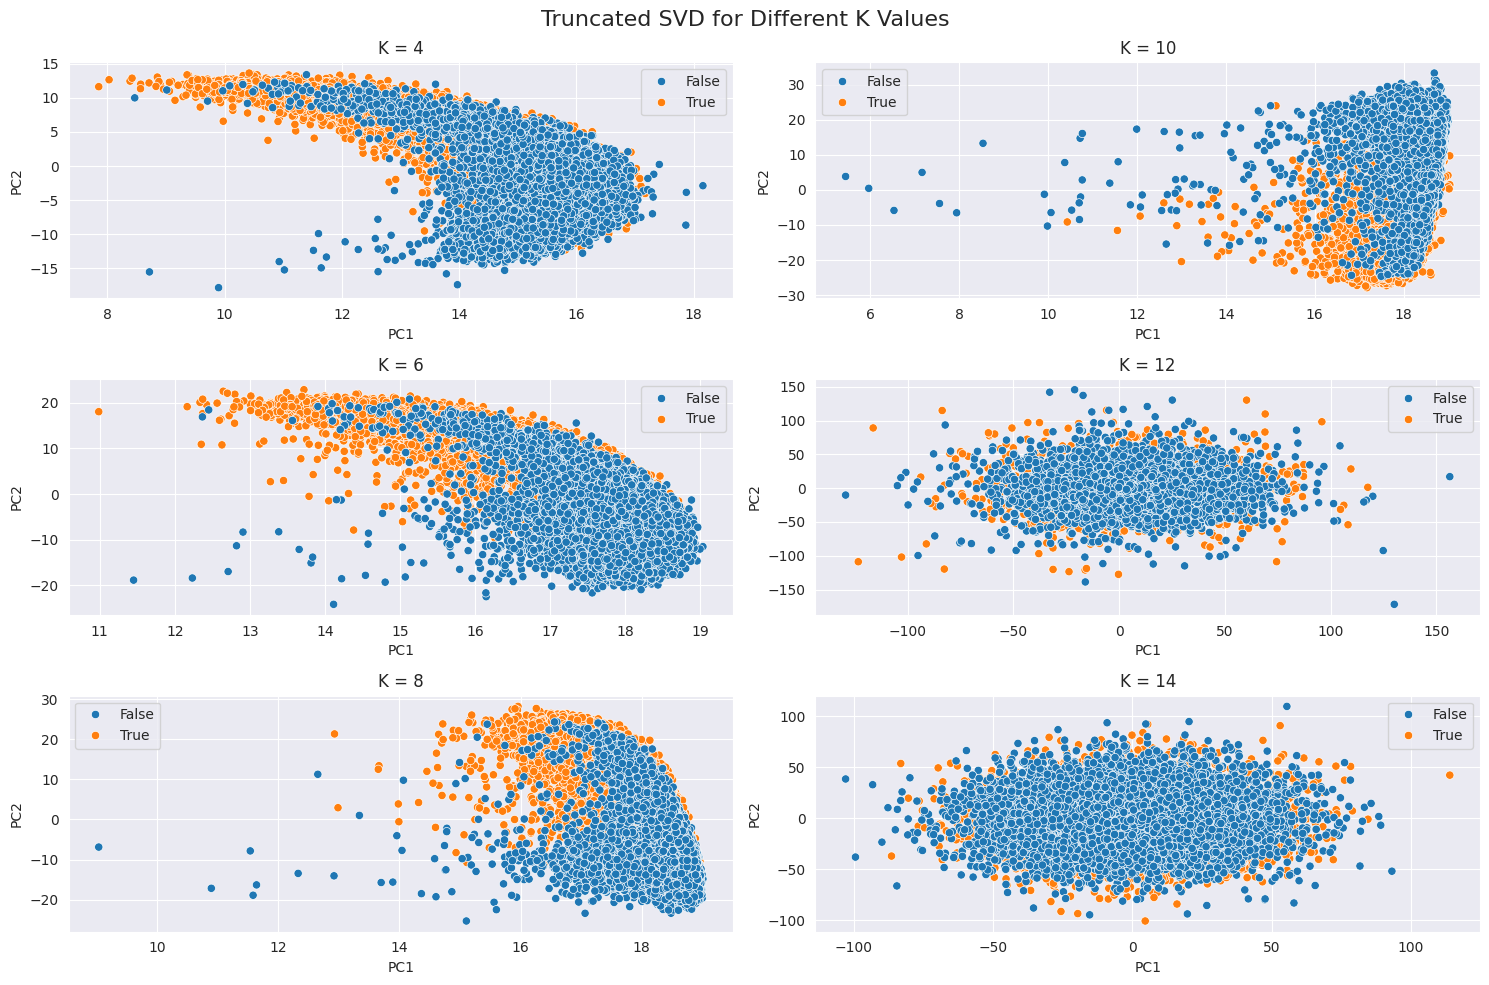

In [9]:

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
for i, K in enumerate([4, 6, 8, 10, 12, 14]):
    # Create pipeline
    svd_pipeline = Pipeline([
        ('kmer', KmerVectorizer(K=K)),
        ('scaler', StandardScaler(with_mean=False)),
        ('svd', TruncatedSVD(n_components=2))
    ])

    # fit and transform the data using truncated svd
    X_svd = svd_pipeline.fit_transform(human['Sequence'].values)
    X_svd = pd.DataFrame(X_svd, columns=['PC1', 'PC2'])
    X_svd['Promoter'] = human['Promoter Status']

    # Plot the data
    j = i // 3
    i = i % 3
    print(i, j)
    sns.scatterplot(data=X_svd, x='PC1', y='PC2', hue='Promoter', ax=ax[i, j])
    ax[i, j].set_title(f"K = {K}")
    ax[i, j].legend()
    fig.suptitle("Truncated SVD for Different K Values", fontsize=16)
    plt.tight_layout()

    plt.savefig('svd_plots.png')

## Implementing a gridsearch function for the rest of the notebook

In [10]:
def gridsearch_with_logging(X_train, y_train, model, param_grid, model_name, cv=5, scoring='accuracy', transform=True, load_existing=True):

    # Check if the model is already trained
    model_file = f'best_{model_name}_model.pkl'
    log_file = f'{model_name}_gridsearch_log.csv'
    if load_existing and os.path.exists(log_file):
        print(f"Model '{model_file}' already exists. Loading the model...")
        best_model = joblib.load(model_file)
        return best_model, None, None

    # Create pipeline
    if transform:
        pipeline = Pipeline([
            ('kmer', KmerVectorizer()),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('model', model)
        ])
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,# Will be controlled by `parallel_backend`
    )

    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    results.to_csv(log_file, index=False)

    # Get the best model and save it
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_file)
    print(f"Best model saved as '{model_file}'")

    return best_model, grid_search.best_params_, grid_search.best_score_


### Implementing a Naive Bayes model via gridsearch, Training on Human

In [11]:
# training Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_param_grid = {
    'kmer__K': [4, 6, 8, 10],
    'model__alpha': [0, 0.1, 0.5, 1.0],
}
best_human_nb_model, best_nb_params, best_nb_score = gridsearch_with_logging(
    train_test_splits['Human']['x_train'], train_test_splits['Human']['y_train'], nb_model, nb_param_grid, 'naive_bayes', load_existing=False
)
# displaying the best parameters and score
print("Best Parameters:", best_nb_params)


/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home

Best model saved as 'best_naive_bayes_model.pkl'
Best Parameters: {'kmer__K': 10, 'model__alpha': 0.1}


### Training naive_bayes on combined data


In [12]:
# training Naive Bayes model
best_combined_nb_model, best_nb_params, best_nb_score = gridsearch_with_logging(
    train_test_splits['Combined']['x_train'], train_test_splits['Combined']['y_train'], nb_model, nb_param_grid, 'naive_bayes_combined', load_existing=False
)
print("Best Parameters:", best_nb_params)

/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/alex/anaconda3/envs/Project2/lib/python3.11/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home

Best model saved as 'best_naive_bayes_combined_model.pkl'
Best Parameters: {'kmer__K': 10, 'model__alpha': 0.1}


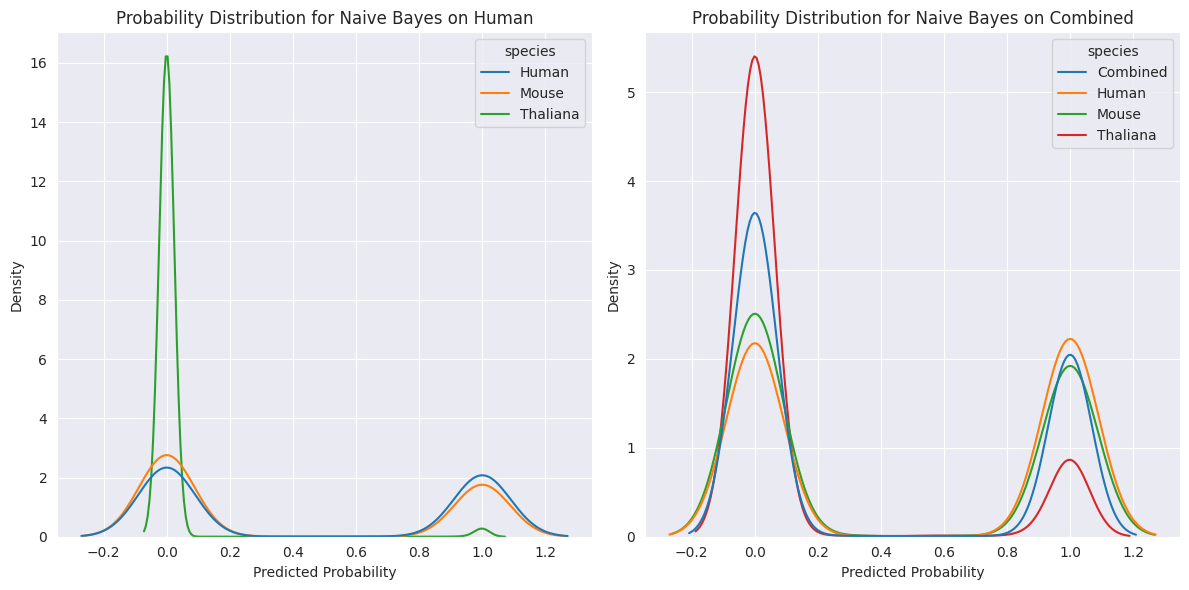

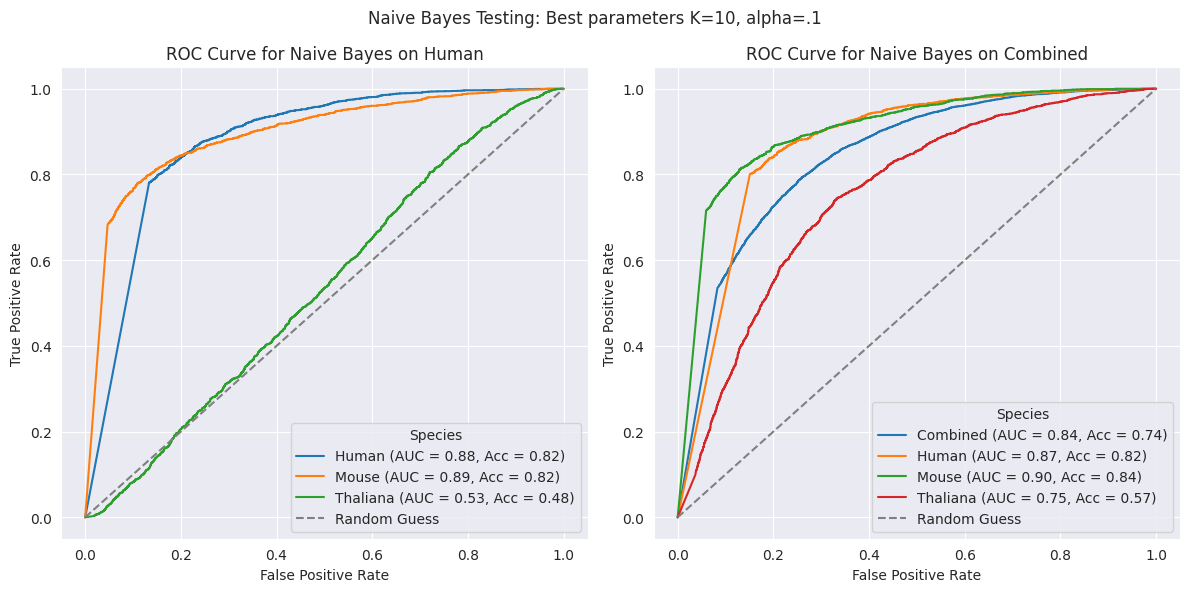

,model,accuracy,precision,recall,f1,roc_auc
species,,,,,,
Human,Naive Bayes on Human,0.823677,0.835246,0.799529,0.816997,0.875731
Mouse,Naive Bayes on Human,0.824643,0.917122,0.713789,0.802780,0.893645
Thaliana,Naive Bayes on Human,0.482233,0.234043,0.008362,0.016147,0.532185
Combined,Naive Bayes on Combined,0.742436,0.835829,0.603553,0.700949,0.841953
Human,Naive Bayes on Combined,0.822132,0.810924,0.832876,0.821753,0.869133
Mouse,Naive Bayes on Combined,0.836810,0.888246,0.770568,0.825233,0.902639
Thaliana,Naive Bayes on Combined,0.568366,0.765416,0.217028,0.338170,0.753936


In [13]:
# evaluating the model on combined test data, human, thaliana, and mouse
fig_prob, ax_prob = plt.subplots(1, 2, figsize=(12, 6))
fig_roc, ax_roc = plt.subplots(1, 2, figsize=(12, 6))
nb_metrics = []
nb_metrics.append(evaluate_model(best_human_nb_model, ['Human','Mouse','Thaliana'], train_test_splits, 'Naive Bayes on Human',ax_prob=ax_prob[0], ax_roc=ax_roc[0]));
nb_metrics.append(evaluate_model(best_combined_nb_model, ['Combined', 'Human','Mouse','Thaliana'], train_test_splits, 'Naive Bayes on Combined',ax_prob=ax_prob[1], ax_roc=ax_roc[1]))
fig_roc.suptitle('Naive Bayes Testing: Best parameters K=10, alpha=.1')
fig_prob.tight_layout()
fig_roc.tight_layout()
fig_prob.savefig("nb_probabilities_comparison.png")
fig_roc.savefig("nb_roc_comparison.png")
plt.show()
consolidated_metrics_df = pd.concat(nb_metrics)
consolidated_metrics_df

### Implementing a Random Forest model via gridsearch, Training on Human

In [14]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'kmer__K': [4, 6, 8, 10,],  # Different k-mer sizes
    'model__n_estimators': [50, 100, 200],  # Number of trees
    'model__max_depth': [10, 20, 50, 100],  # Maximum depth of the trees
    'model__min_samples_split': [2],
}
# Perform grid search with logging
best_human_rf_model, best_rf_params, best_rf_score = gridsearch_with_logging(
    X_train= train_test_splits['Human']['x_train'],
    y_train=train_test_splits['Human']['y_train'],
    model=model,
    param_grid=param_grid,
    model_name='random_forest',
    cv=5,
    scoring='accuracy',
    load_existing=False
)
print("Best Parameters:", best_rf_params)

Best model saved as 'best_random_forest_model.pkl'
Best Parameters: {'kmer__K': 8, 'model__max_depth': 100, 'model__min_samples_split': 2, 'model__n_estimators': 200}


### Training Random Forest on Combined Data

In [16]:
# training Random Forest model on combined data
best_combined_rf_model, best_rf_params, best_rf_score = gridsearch_with_logging(
    X_train=train_test_splits['Combined']['x_train'],
    y_train=train_test_splits['Combined']['y_train'],
    model=model,
    param_grid=param_grid,
    model_name='random_forest',
    cv=5,
    scoring='accuracy',
    load_existing=False
)
print("Best Parameters:", best_rf_params)

Best model saved as 'best_random_forest_model.pkl'
Best Parameters: {'kmer__K': 4, 'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}


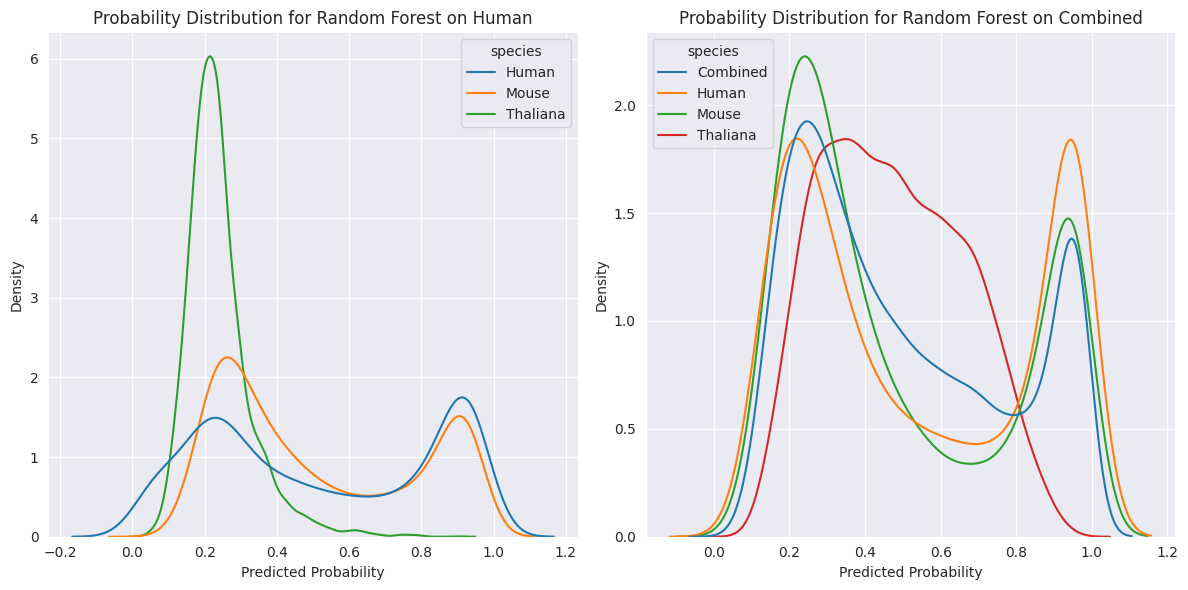

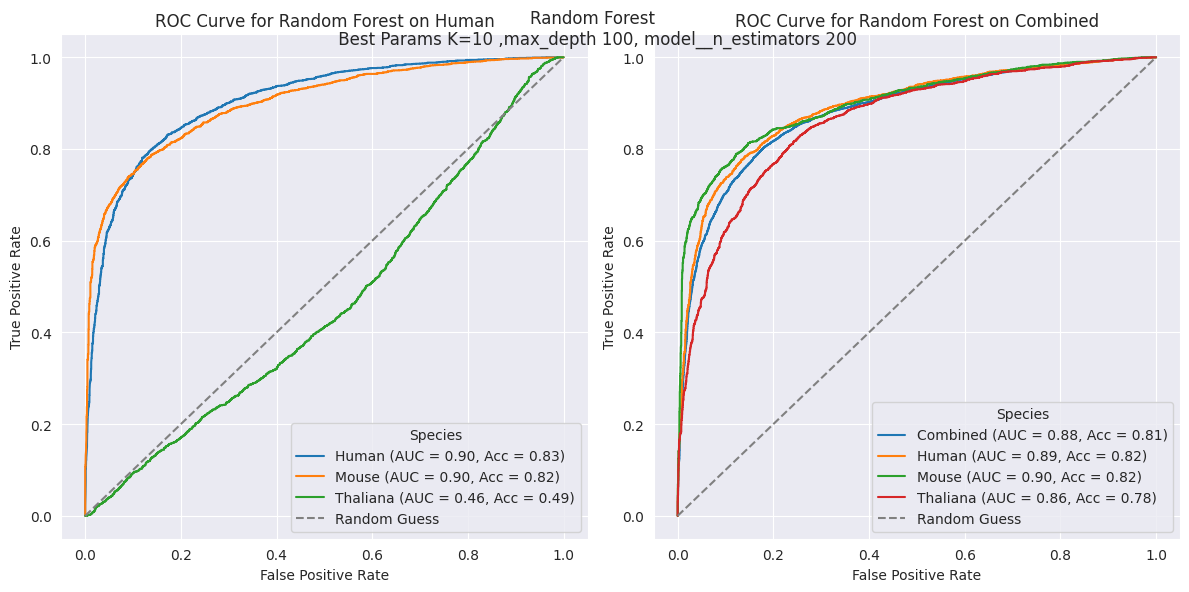

,model,accuracy,precision,recall,f1,roc_auc
species,,,,,,
Human,Random Forest on Human,0.828119,0.832999,0.814045,0.823413,0.904753
Mouse,Random Forest on Human,0.822905,0.881735,0.745848,0.808119,0.900831
Thaliana,Random Forest on Human,0.489185,0.427083,0.015583,0.030070,0.459127
Combined,Random Forest on Combined,0.806875,0.861671,0.731240,0.791115,0.882124
Human,Random Forest on Combined,0.820394,0.836311,0.789721,0.812349,0.891490
Mouse,Random Forest on Combined,0.823291,0.927041,0.701815,0.798857,0.900506
Thaliana,Random Forest on Combined,0.776941,0.831536,0.703535,0.762199,0.861458


In [35]:
# evaluating the model on combined data, human, thaliana, and mouse
fig_prob, ax_prob = plt.subplots(1, 2, figsize=(12, 6))
fig_roc, ax_roc = plt.subplots(1, 2, figsize=(12, 6))
rf_metrics =[]
rf_metrics.append(evaluate_model(best_human_rf_model, [ 'Human','Mouse','Thaliana'], train_test_splits, 'Random Forest on Human',ax_prob=ax_prob[0], ax_roc=ax_roc[0]));
rf_metrics.append(evaluate_model(best_combined_rf_model, ['Combined', 'Human','Mouse','Thaliana'], train_test_splits, 'Random Forest on Combined',ax_prob=ax_prob[1], ax_roc=ax_roc[1]))
fig_prob.tight_layout()
fig_roc.tight_layout()
fig_roc.suptitle('Random Forest \n Best Params K=10 ,max_depth 100, model__n_estimators 200')
fig_prob.savefig("rf_probabilities_comparison.png")
fig_roc.savefig("rf_roc_comparison.png")
plt.show()
consolidated_metrics_df = pd.concat(rf_metrics)
consolidated_metrics_df

## Implementing a SVM model via gridsearch, Training on Human, using TruncatedSVD to reduce dimensionality


In [18]:
# svd_pipeline = Pipeline([
#     ('kmer', KmerVectorizer(K=10)),
#     ('scaler', StandardScaler(with_mean=False)),
#     ('svd', TruncatedSVD(n_components=10))
# ])
# full_data_reduced = svd_pipeline.fit_transform(human['Sequence'].values)
# reduced_x_train = svd_pipeline.transform(train_test_splits['Human']['x_train'])

In [19]:
# # training SVM model
# from sklearn.svm import SVC
# model = SVC(probability=True)
# param_grid = {
#     'model__C': [0.1, 1, 10],
#     'model__gamma': ['scale', 'auto'],
#     'model__kernel': ['linear', 'rbf'],
# }
#
# best_human_svm_model, best_svm_params, best_svm_score = gridsearch_with_logging(
#     X_train=reduced_x_train,
#     y_train=train_test_splits['Human']['y_train'],
#     model=model,
#     param_grid=param_grid,
#     model_name='svm',
#     cv=5,
#     scoring='accuracy',
#     transform=False,
#     load_existing=False
# )
# print("Best Parameters:", best_svm_params)

### Training SVM on Combined Data

In [20]:
# # training SVM model on combined data
# combined_pipeline = svd_pipeline
# combined_pipeline.fit_transform(combined_data['Sequence'].values)
# best_combined_svm_model, best_svm_params, best_svm_score = gridsearch_with_logging(
#     X_train=combined_pipeline.transform(train_test_splits['Combined']['x_train']),
#     y_train=train_test_splits['Combined']['y_train'],
#     model=model,
#     param_grid=param_grid,
#     model_name='svm',
#     cv=5,
#     scoring='accuracy',
#     transform=False,
#     load_existing=False
# )
# print("Best Parameters:", best_svm_params)

### Evaluating SVM model on Combined Data, Human, Thaliana, and Mouse

In [21]:
# # evaluating the model on combined data, human, thaliana, and mouse
# svm_metrics = []
# fig_prob, ax_prob = plt.subplots(1, 2, figsize=(12, 6))
# fig_roc, ax_roc = plt.subplots(1, 2, figsize=(12, 6))
# rf_transformed_dict = {}
# for species in ['Human', 'Thaliana', 'Mouse']:
#     rf_transformed_dict[species] = {}
#     rf_transformed_dict[species]['x_test'] = svd_pipeline.transform(train_test_splits[species]['x_test'])
#     rf_transformed_dict[species]['y_test'] = train_test_splits['Human']['y_test']
# svm_metrics.append(evaluate_model(best_human_svm_model, [ 'Human','Mouse','Thaliana'], rf_transformed_dict, 'SVM on Human', ax_prob=ax_prob[0], ax_roc=ax_roc[0]));
# rf_transformed_dict = {}
# for species in ['Combined', 'Human', 'Thaliana', 'Mouse']:
#     rf_transformed_dict[species] = {}
#     rf_transformed_dict[species]['x_test'] = combined_pipeline.transform(train_test_splits[species]['x_test'])
#     rf_transformed_dict[species]['y_test'] = train_test_splits['Human']['y_test']
# svm_metrics.append(evaluate_model(best_human_svm_model, ['Combined', 'Human','Mouse','Thaliana'], rf_transformed_dict, 'SVM on Combined', ax_prob=ax_prob[1], ax_roc=ax_roc[1]))
# fig_prob.tight_layout()
# fig_roc.tight_layout()
# fig_prob.savefig("svm_probabilities_comparison.png")
# fig_roc.savefig("svm_roc_comparison.png")
# plt.show()
# consolidated_metrics_df = pd.concat(svm_metrics)
# consolidated_metrics_df


# Implementing a simple MLP model, with using keras

In [22]:
# Creating a mutation layer
class RandomMutationLayer(Layer):
    def __init__(self, mutation_rate=0.05, vocab_size=5, **kwargs):
        super(RandomMutationLayer, self).__init__(**kwargs)
        self.mutation_rate = mutation_rate
        self.vocab_size = vocab_size  # Include 0 for padding and 1-4 for nucleotides

    def call(self, inputs, training=None):
        if not training:
            return inputs  # No mutations during inference
        mutation_mask = tf.random.uniform(shape=tf.shape(inputs)) < self.mutation_rate
        random_mutations = tf.random.uniform(
            shape=tf.shape(inputs),
            minval=1, maxval=self.vocab_size,
            dtype=tf.int32
        )
        return tf.where(mutation_mask, random_mutations, inputs)

def create_kmer_model_with_transform(X_train_sequences, k=4, hidden_nodes=256, dropout_rate=0.2):
    # conversion to tensor
    X_train_sequences = tf.constant(X_train_sequences, dtype=tf.string)

    text_vectorization = TextVectorization(
        standardize=None,
        split='character',
        ngrams=k,
        output_mode='count',
    )
    # applying vectorization (kmer transform)
    text_vectorization.adapt(tf.data.Dataset.from_tensor_slices(X_train_sequences).batch(32))

    # Building the model
    model = Sequential([

        text_vectorization,
        Lambda(lambda x: tf.cast(x, tf.float32)),  # Cast counts to float32
        Dense(hidden_nodes, activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_nodes // 2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

In [23]:
# visualzing the model


In [24]:
# creating validation data for human and combined data
human_x_train = train_test_splits['Human']['x_train']
human_y_train = train_test_splits['Human']['y_train']
train_test_splits['Human']['x_train'], train_test_splits['Human']['x_val'], train_test_splits['Human']['y_train'], train_test_splits['Human']['y_val'] = train_test_split(human_x_train, human_y_train, test_size=0.2)
combined_x_train = train_test_splits['Combined']['x_train']
combined_y_train = train_test_splits['Combined']['y_train']
train_test_splits['Combined']['x_train'], train_test_splits['Combined']['x_val'], train_test_splits['Combined']['y_train'], train_test_splits['Combined']['y_val'] = train_test_split(combined_x_train, combined_y_train, test_size=0.2)


In [25]:
# creating a dictionary of the tensor datasets
project_tensors = {}
for species in train_test_splits.keys():
    project_tensors[species] = {}
    for split in ['train', 'val', 'test']:
        if f'x_{split}' in train_test_splits[species].keys():
            project_tensors[species][split] = tf.data.Dataset.from_tensor_slices((tf.constant(train_test_splits[species][f'x_{split}'], dtype=tf.string), tf.constant(train_test_splits[species][f'y_{split}'], dtype=tf.int32))).batch(32)


I0000 00:00:1733644196.325330  311721 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6
I0000 00:00:1733644196.327655  311721 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22341 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6
I0000 00:00:1733644196.329816  311721 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22341 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c2:00.0, compute capability: 8.6


In [26]:
k_values = [4, 6, 8, 10]
kmer_models = []
kmer_model_names = []

for k in k_values:
    model_name = f'{k}mer MLP'
    print(f"Training model {model_name}...")
    model = create_kmer_model_with_transform(human['Sequence'].values, k=k, hidden_nodes=256, dropout_rate=0.2)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )
    model_checkpoint = ModelCheckpoint(
        filepath=f'{model_name}_best_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
    model.fit(
        project_tensors['Human']['train'],
        epochs=20,
        validation_data=project_tensors['Human']['val'],
        callbacks=[early_stopping, lr_scheduler, model_checkpoint],
        verbose=0
    )
    print(f"Model saved as '{model_name}_best_model.keras'")
    kmer_models.append(model)
    kmer_model_names.append(model_name)

Training model 4mer MLP...


2024-12-07 23:50:08.897052: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Model saved as '4mer MLP_best_model.keras'
Training model 6mer MLP...


2024-12-07 23:53:48.861866: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Model saved as '6mer MLP_best_model.keras'
Training model 8mer MLP...

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Model saved as '8mer MLP_best_model.keras'
Training model 10mer MLP...


2024-12-08 00:00:54.457916: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Model saved as '10mer MLP_best_model.keras'


In [27]:
kmer_models[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 351)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 351)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        90,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,413 (1.41 MB)

 Trainable params: 123,137 (481.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 246,276 (962.02 KB)

### Evaluating Kmer models on Human, Thaliana, and Mouse


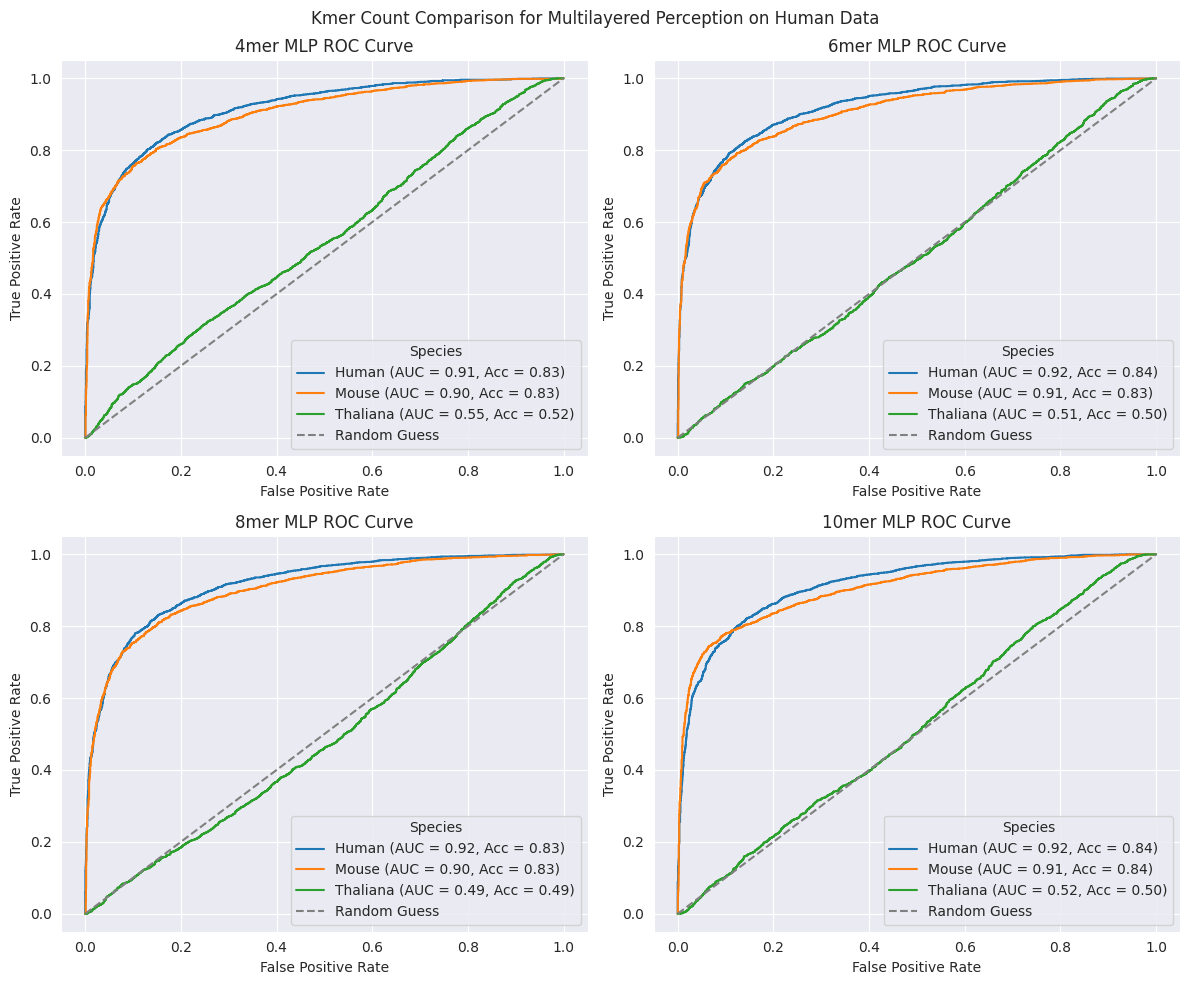

,model,accuracy,precision,recall,f1,roc_auc
species,,,,,,
Human,4mer MLP On Human,0.833913,0.828216,0.836014,0.832097,0.914043
Mouse,4mer MLP On Human,0.826574,0.852733,0.789494,0.819896,0.902348
Thaliana,4mer MLP On Human,0.524141,0.581623,0.226150,0.325670,0.545635
Human,6mer MLP On Human,0.840479,0.842817,0.830914,0.836823,0.920206
Mouse,6mer MLP On Human,0.831595,0.867037,0.783314,0.823052,0.907125
Thaliana,6mer MLP On Human,0.495751,0.512315,0.158115,0.241650,0.505206
Human,8mer MLP On Human,0.834106,0.824252,0.842683,0.833366,0.915909
Mouse,8mer MLP On Human,0.827346,0.850351,0.794515,0.821486,0.902457
Thaliana,8mer MLP On Human,0.493627,0.507365,0.117826,0.191240,0.485633


In [28]:
import matplotlib.pyplot as plt
model_metrics = []
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
model_metrics = []
for idx, (model, model_name) in enumerate(zip(kmer_models, kmer_model_names)):
    ax_roc = axes[idx]
    model_metrics.append(evaluate_model(model,['Human', 'Mouse', 'Thaliana'],train_test_splits, model_name + ' On Human',probability=False,  ax_roc=ax_roc))
    ax_roc.set_title(f"{model_name} ROC Curve")

fig.suptitle('Kmer Count Comparison for Multilayered Perception on Human Data')
plt.tight_layout()
plt.savefig("human_kmer_mlp_roc.png")
model_metrics = pd.concat(model_metrics)
plt.show()
model_metrics


### Training the best model on combined data


In [29]:
# training the best model on combined data
best_kmer_model_combined = kmer_models[3]
best_kmer_model_name = kmer_model_names[3]
best_kmer_model_combined.fit(
    project_tensors['Combined']['train'],
    epochs=20,
    validation_data=project_tensors['Combined']['val'],
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
    verbose=0
)


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


### Evaluating the best model on Combined Data, Human, Thaliana, and Mouse

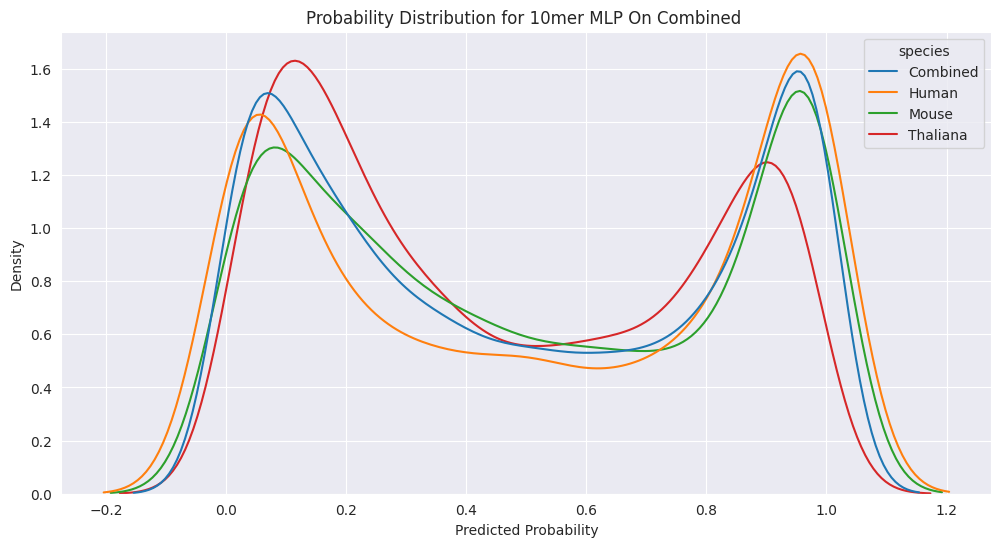

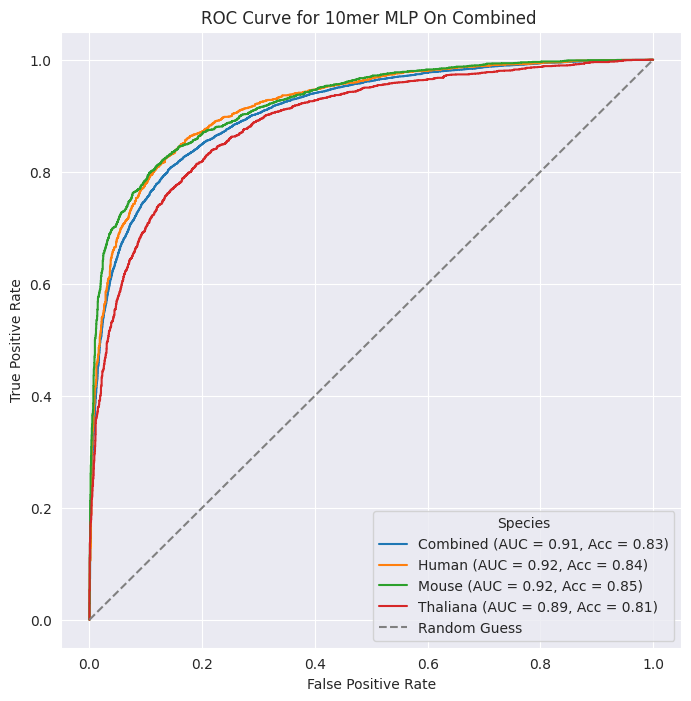

,model,accuracy,precision,recall,f1,roc_auc
species,,,,,,
Combined,10mer MLP On Combined,0.831595,0.849735,0.805767,0.827167,0.909857
Human,10mer MLP On Combined,0.842410,0.828344,0.857591,0.842714,0.919818
Mouse,10mer MLP On Combined,0.845114,0.861302,0.822711,0.841565,0.923623
Thaliana,10mer MLP On Combined,0.807261,0.862084,0.738883,0.795743,0.891246


In [30]:
# Evaluate the best model on the test sets
best_kmer_model_name = kmer_model_names[3]
evaluate_model(best_kmer_model_combined, ['Combined', 'Human', 'Mouse', 'Thaliana'], train_test_splits, best_kmer_model_name+' On Combined ')

## Implementing a more advanced Transformer based model using keras

In [31]:
# DNA Tokenization Function
def dna_tokenizer(sequence, vocab={'A': 1, 'C': 2, 'G': 3, 'T': 4,'N':5}, max_length=None):
    tokens = [vocab.get(nuc, 0) for nuc in sequence]  # Map nucleotides to integers
    if max_length:
        tokens = tokens[:max_length] + [0] * max(0, max_length - len(tokens))  # Pad to max_length
    return tokens

def transformer_block(inputs, embed_dim, num_heads, ff_dim, dropout_rate=0.5):
    # setup content and positional bias weights of dimension [num_heads, embed_dim]
    attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    attention_output = attention_layer(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    # MLP
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(embed_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    sequence_output = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

    return sequence_output

# implementing a mutation layer to avoid overfitting

def create_embedding_model_with_transformer(
        max_length, vocab_size, embedding_dim=64,
):
    inputs = Input(shape=(max_length,), dtype=tf.int32)
    mutations = RandomMutationLayer(mutation_rate=0.05, vocab_size=vocab_size)(inputs)
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(mutations)
    positional_encoding = keras_hub.layers.SinePositionEncoding(max_wavelength=1000)(embedding)
    embedding = embedding + positional_encoding
    conv = Conv1D(filters=64, kernel_size=10, activation='relu', padding='same')(embedding)
    conv = MaxPooling1D(pool_size=4)(conv)
    # lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    # attention =MultiHeadAttention(num_heads=8, key_dim=embedding_dim)(lstm, lstm)
    # adding pass through connection
    for i in range(2):
        x = transformer_block(conv, embedding_dim, 8, 256,  dropout_rate=0.5)
    # add passthrough
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    focal_loss = tf.keras.losses.BinaryFocalCrossentropy()
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy', 'AUC'])
    return model

def prepare_dna_data(data_dict, max_length):
    # Tokenize DNA sequences
    vocab = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
    x_train_tokenized = data_dict['x_train'].apply(lambda seq: dna_tokenizer(seq, vocab, max_length))
    x_val_tokenized = data_dict['x_val'].apply(lambda seq: dna_tokenizer(seq, vocab, max_length))

    x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_tokenized, maxlen=max_length)
    x_val_padded = tf.keras.preprocessing.sequence.pad_sequences(x_val_tokenized, maxlen=max_length)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_padded, data_dict['y_train'])).batch(32)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val_padded, data_dict['y_val'])).batch(32)

    return train_dataset, val_dataset, max_length, len(vocab) + 1





In [32]:
# training the model on human data, with k=1
x_train, x_val, max_length, vocab_size = prepare_dna_data(train_test_splits['Human'], 350)
transformer_model = create_embedding_model_with_transformer(max_length, vocab_size, embedding_dim=64)
transformer_model.fit(x_train,  validation_data=x_val, epochs=20, callbacks=[early_stopping, lr_scheduler, model_checkpoint],verbose=0)

I0000 00:00:1733647255.733732  326857 service.cc:148] XLA service 0x7d3c4d454b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733647255.733790  326857 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1733647255.733798  326857 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1733647255.733803  326857 service.cc:156]   StreamExecutor device (2): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-08 00:40:55.848356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-08 00:40:55.927217: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. functiona


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


### Evaluating the Transformer model on Human, Thaliana, and Mouse


In [33]:
# training the model on combined data
transformer_model.save('attention_model.keras')
x_train, x_val, max_length, vocab_size = prepare_dna_data(train_test_splits['Combined'], 350)
combined_transformer_model = create_embedding_model_with_transformer(max_length, vocab_size, embedding_dim=64)
combined_transformer_model.fit(x_train,  validation_data=x_val, epochs=20, callbacks=[early_stopping, lr_scheduler, model_checkpoint],verbose=0)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


### Evaluating the Transformer model on Combined Data, Human, Thaliana, and Mouse

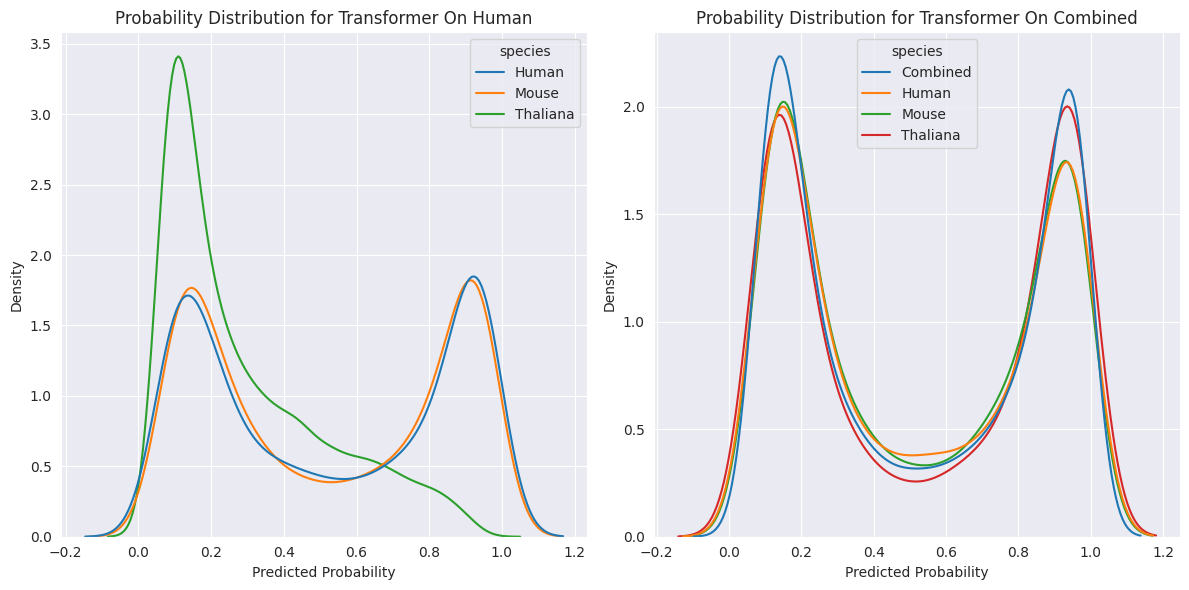

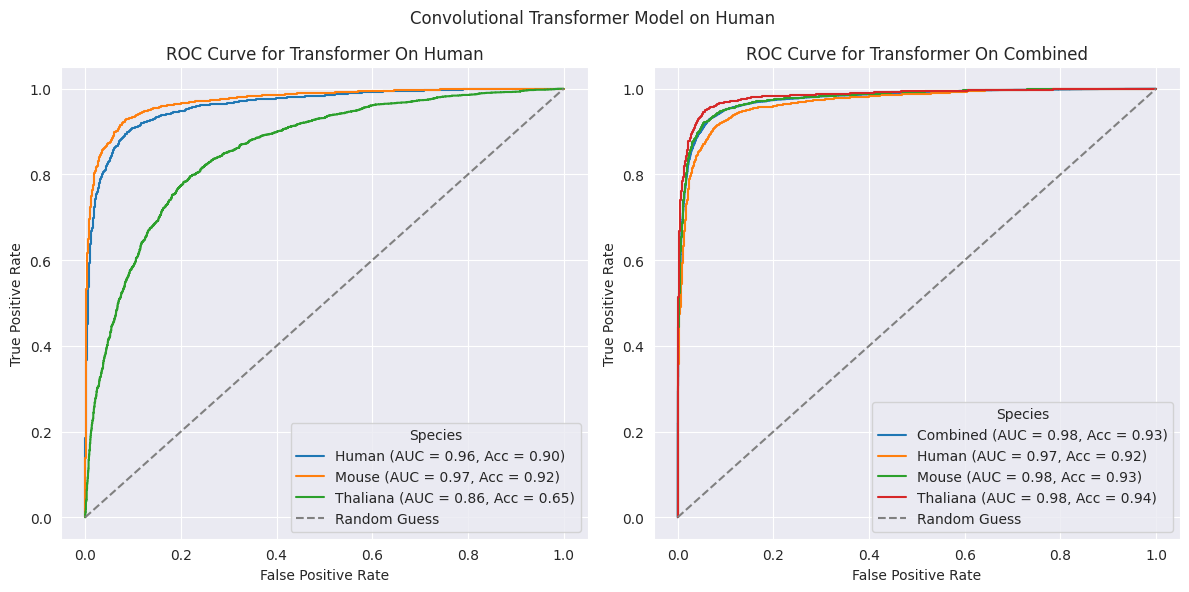

,model,accuracy,precision,recall,f1,roc_auc
species,,,,,,
Human,Transformer On Human,0.900348,0.887533,0.913299,0.900232,0.961218
Mouse,Transformer On Human,0.921398,0.920262,0.922750,0.921504,0.972559
Thaliana,Transformer On Human,0.647740,0.911315,0.339795,0.495017,0.857808
Combined,Transformer On Combined,0.930733,0.936140,0.924572,0.930320,0.975986
Human,Transformer On Combined,0.915604,0.920717,0.906630,0.913619,0.967268
Mouse,Transformer On Combined,0.931634,0.946108,0.915411,0.930506,0.977034
Thaliana,Transformer On Combined,0.944959,0.941309,0.950969,0.946115,0.983066


In [34]:
# Evaluate the model on the test sets
# Evaluate the model on the test sets
fig_prob, ax_prob = plt.subplots(1, 2, figsize=(12, 6))
fig_roc, ax_roc = plt.subplots(1, 2, figsize=(12, 6))
transformer_metrics = []
transformer_metrics.append(evaluate_model(transformer_model, ['Human', 'Mouse', 'Thaliana'], train_test_splits, 'Transformer On Human', max_length=max_length, attention=True, ax_prob=ax_prob[0], ax_roc=ax_roc[0]));
transformer_metrics.append(evaluate_model(combined_transformer_model, ['Combined', 'Human', 'Mouse', 'Thaliana'], train_test_splits, 'Transformer On Combined', max_length=max_length, attention=True, ax_prob=ax_prob[1], ax_roc=ax_roc[1]))
fig_roc.suptitle('Convolutional Transformer Model on Human ')
fig_prob.tight_layout()
fig_roc.tight_layout()
fig_prob.savefig("transformer_probabilities_comparison.png")
fig_roc.savefig("transformer_roc_comparison.png")
plt.show()
consolidated_metrics_df = pd.concat(transformer_metrics)
consolidated_metrics_df